# OTT vs. POT

The [Python Optimal Transport (POT)](https://pythonot.github.io/) toolbox paved the way for much progress in OT. `POT` implements several OT solvers (LP and regularized), and is complemented with various tools (barycenters, domain adaptation, Gromov-Wasserstein distances, sliced W, etc.).

The goal of this notebook is to compare the performance `OTT`'s {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` and `POT`'s {func}`~ot.sinkhorn` solvers. `OTT` benefits from just-in-time compilation, which should give it an edge.

The comparisons carried out below have limitations: minor modifications in the setup (e.g. data distributions, tolerance thresholds, type of accelerator...) could have an impact on these results. Feel free to change these settings and experiment by yourself!

## Installs toolboxes

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install -q POT

In [2]:
import timeit

import jax
import jax.numpy as jnp
import numpy as np
import ot

import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

In [3]:
plt.rc("font", size=20)

## Regularized OT in a nutshell

We consider two probability measures $\mu,\nu$ compared with the squared-Euclidean distance, $c(x,y)=\|x-y\|^2$. These measures are discrete and of the same size in this notebook:

$$\mu=\sum_{i=1}^n a_i\delta_{x_i}, \nu =\sum_{j=1}^n b_j\delta_{y_j},$$

to define the OT problem in its primal form,
$$\min_{P \in U(a,b)} \langle C, P \rangle - \varepsilon H(P).$$

where $U(a,b):=\{P \in \mathbf{R}_+^{n\times n}, P\mathbf{1}_{n}=b, P^T\mathbf{1}_n=b\}$, and $C = [ \|x_i - y_j \|^2 ]_{i,j}\in \mathbf{R}_+^{n\times n}$.

That problem is equivalent to the following dual form,
$$\max_{f, g} \langle a, f \rangle + \langle b, g \rangle - \varepsilon \langle e^{f/\varepsilon},Ke^{g/\varepsilon} \rangle.$$

These two problems are solved by `OTT` and `POT` using the *Sinkhorn iterations* using a simple initialization for $u$, and subsequent updates $v \leftarrow a / K^Tu, u \leftarrow b / Kv$,  where $K:=e^{-C/\varepsilon}$.

Upon convergence to fixed points $u^*, v^*$, one has $$P^*=D(u^*)KD(v^*)$$ or, alternatively, 
$$f^*, g^* = \varepsilon \log(u^*), \varepsilon\log(v^*)$$

## OTT and POT implementation

Both toolboxes carry out Sinkhorn updates using either the formulas above directly (this corresponds to `lse_mode=False` in `OTT` and `method='sinkhorn'` in `POT`) or using slightly slower but more robust approaches:

`OTT` relies on log-space iterations (`lse_mode=True`), whereas `POT`, uses a stabilization trick , using the `method='sinkhorn_stabilized'` flag, designed to avoid numerical overflows, while still benefitting from the speed given by matrix vector products. 

The default behaviour of `OTT` and [POT](https://github.com/PythonOT/POT/blob/f6139428e70ce964de3bef703ef13aa701a83620/ot/bregman.py#L413) is to carry out these updates until $\|u\circ Kv - a\|_2 + \|v\circ K^Tu - b\|_2$ is smaller than the user-defined `threshold`.

## Common API for `OTT` and `POT`

We will compare in our experiments  `OTT` vs. `POT` in their more stable setups (`lse_mode` and `stabilized`). We define a common API for both, making sure their results are comparable. That API takes as inputs the measures' info, the targeted $\varepsilon$ value and the `threshold` used to terminate the algorithm. We set a maximum of 1000 iterations for both.

In [6]:
def solve_ot(a, b, x, y, 𝜀, threshold):
    _, log = ot.sinkhorn(
        a,
        b,
        ot.dist(x, y),
        𝜀,
        stopThr=threshold,
        method="sinkhorn_stabilized",
        log=True,
        numItermax=1000,
    )
    f, g = 𝜀 * log["logu"], 𝜀 * log["logv"]
    f, g = f - np.mean(f), g + np.mean(
        f
    )  # center variables, useful if one wants to compare them
    reg_ot = (
        np.sum(f * a) + np.sum(g * b) if log["err"][-1] < threshold else np.nan
    )
    return f, g, reg_ot


@jax.jit
def solve_ott(a, b, x, y, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=a, b=b)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold, lse_mode=True, max_iterations=1000
    )
    out = solver(prob)

    f, g = out.f, out.g
    f, g = f - np.mean(f), g + np.mean(
        f
    )  # center variables, useful if one wants to compare them
    reg_ot = jnp.where(out.converged, jnp.sum(f * a) + jnp.sum(g * b), jnp.nan)
    return f, g, reg_ot

To test both solvers, we run simulations using a random seed to generate random point clouds of size $n$. Random generation is carried out using {func}`jax.random.PRNGKey`, to ensure reproducibility. A solver provides three pieces of info: the function (using our simple common API), its numerical environment and its name.

In [7]:
dim = 3


def run_simulation(rng, n, 𝜀, threshold, solver_spec):
    #  setting global variables helps avoir a timeit bug.
    global solver_
    global a, b, x, y

    # extract specificities of solver.
    solver_, env, name = solver_spec

    # draw data at random using JAX
    rng, *rngs = jax.random.split(rng, 5)
    x = jax.random.uniform(rngs[0], (n, dim))
    y = jax.random.uniform(rngs[1], (n, dim)) + 0.1
    a = jax.random.uniform(rngs[2], (n,))
    b = jax.random.uniform(rngs[3], (n,))
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)

    # map to numpy if needed
    if env == "np":
        a, b, x, y = map(np.array, (a, b, x, y))

    timeit_res = %timeit -o solver_(a, b, x, y, 𝜀, threshold)
    out = solver_(a, b, x, y, 𝜀, threshold)
    exec_time = np.nan if np.isnan(out[-1]) else timeit_res.best
    return exec_time, out

Defines the two solvers used in this experiment:

In [8]:
POT = (solve_ot, "np", "POT")
OTT = (solve_ott, "jax", "OTT")

## Runs simulations with varying $n$ and $\varepsilon$
We run simulations by setting the regularization strength 𝜀 to either $10^{-2}$ or $10^{-1}$.

We consider $n$ between sizes $2^{8}= 256$ and $2^{12}= 4096$.  We do not go higher, because `POT` runs into out-of-memory errors for $2^{13}=8192$ in this RAM restricted colab environment. `OTT` can avoid these by setting the flag `batch_size` to, e.g., `1024`, as done in the tutorial for grids, and also handled by the [GeomLoss](https://www.kernel-operations.io/geomloss/) toolbox. We leave the comparison with `geomloss` to a different NB. 

When `%timeit` outputs execution time, **notice the warning message** highlighting the fact that, for `OTT`, at least one run took significantly longer. That run is that doing the **JIT pre-compilation** of the procedure, suitable for that particular problem size $n$. Once pre-compiled, subsequent runs are order of magnitudes faster, thanks to the {func}`jax.jit` decorator added to `solve_ott`.

In [6]:
rng = jax.random.PRNGKey(0)
solvers = (POT, OTT)
n_range = 2 ** np.arange(8, 13)
𝜀_range = 10 ** np.arange(-2.0, 0.0)

threshold = 1e-2

exec_time = {}
reg_ot = {}
for solver_spec in solvers:
    solver, env, name = solver_spec
    print("----- ", name)
    exec_time[name] = np.ones((len(n_range), len(𝜀_range))) * np.nan
    reg_ot[name] = np.ones((len(n_range), len(𝜀_range))) * np.nan
    for i, n in enumerate(n_range):
        for j, 𝜀 in enumerate(𝜀_range):
            t, out = run_simulation(rng, n, 𝜀, threshold, solver_spec)
            exec_time[name][i, j] = t
            reg_ot[name][i, j] = out[-1]

-----  POT
10 loops, best of 5: 43.7 ms per loop
100 loops, best of 5: 11.9 ms per loop
1 loop, best of 5: 230 ms per loop
10 loops, best of 5: 41.4 ms per loop
1 loop, best of 5: 33.4 s per loop
10 loops, best of 5: 155 ms per loop
1 loop, best of 5: 2min 13s per loop
1 loop, best of 5: 367 ms per loop
1 loop, best of 5: 6min 21s per loop
1 loop, best of 5: 1.22 s per loop
-----  OTT
The slowest run took 66.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 11.2 ms per loop
1000 loops, best of 5: 1.04 ms per loop
The slowest run took 128.37 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 6.12 ms per loop
1000 loops, best of 5: 1.08 ms per loop
The slowest run took 94.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 8.95 ms per loop
1000 loops, best of 5: 1.42 ms per loop
The slowest run took 33.90

## Plots results in terms of time and difference in objective

When the algorithm does not converge within the maximal number of 1000 iterations, or runs into numerical issues, the solver returns a NaN and that point does not appear in the plot.

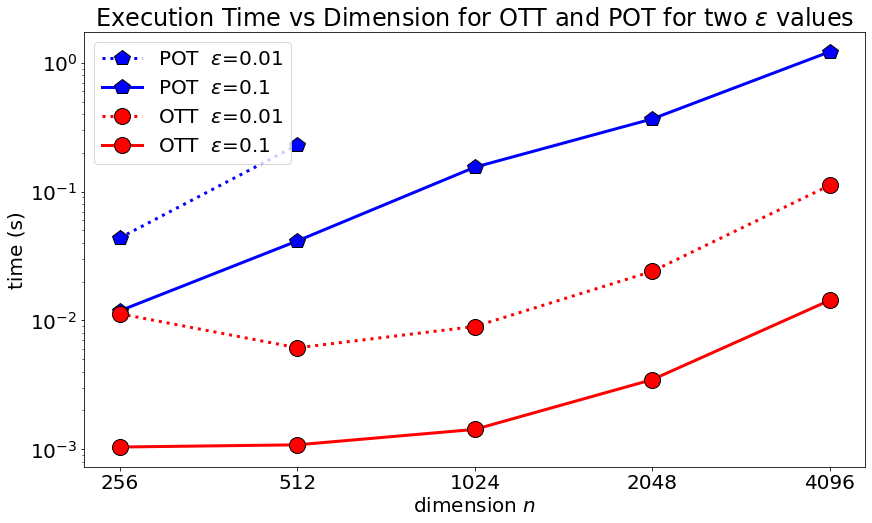

In [24]:
list_legend = []
fig = plt.figure(figsize=(14, 8))

for solver_spec, marker, col in zip(solvers, ("p", "o"), ("blue", "red")):
    solver, env, name = solver_spec
    p = plt.plot(
        exec_time[name],
        marker=marker,
        color=col,
        markersize=16,
        markeredgecolor="k",
        lw=3,
    )
    p[0].set_linestyle("dotted")
    p[1].set_linestyle("solid")
    list_legend += [name + r"  $\varepsilon $=" + f"{𝜀:.2g}" for 𝜀 in 𝜀_range]

plt.xticks(ticks=np.arange(len(n_range)), labels=n_range)
plt.legend(list_legend)
plt.yscale("log")
plt.xlabel("dimension $n$")
plt.ylabel("time (s)")
plt.title(
    r"Execution Time vs Dimension for OTT and POT for two $\varepsilon$ values"
)
plt.show()

For good measure, we also show the differences in *objectives* between the two solvers. We substract the objective returned by `POT` to that returned by `OTT`.

Since the problem is evaluated in its dual form, a *higher* objective is *better*, and therefore a positive difference denotes better performance for `OTT`. White areas stand for values for which `POT` did not converge (either because it has exhausted the maximal number of iterations or experienced numerical issues).

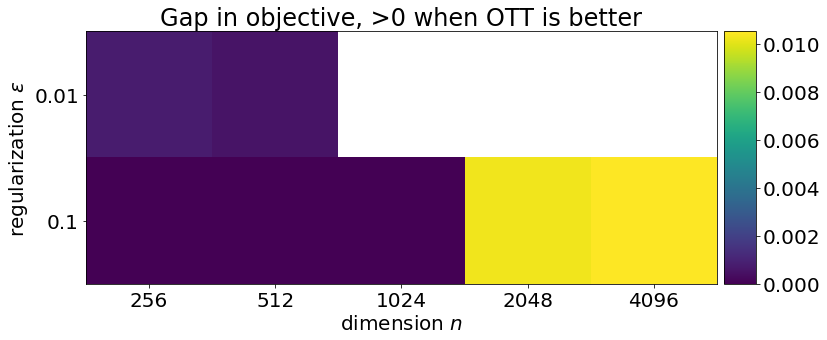

In [21]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()
im = ax.imshow(reg_ot["OTT"].T - reg_ot["POT"].T)
plt.xticks(ticks=np.arange(len(n_range)), labels=n_range)
plt.yticks(ticks=np.arange(len(𝜀_range)), labels=𝜀_range)
plt.xlabel("dimension $n$")
plt.ylabel(r"regularization $\varepsilon$")
plt.title("Gap in objective, >0 when OTT is better")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.show()

In [45]:
for name in ("POT", "OTT"):
    print("----", name)
    print("Objective")
    print(reg_ot[name])
    print("Execution Time")
    print(exec_time[name])

---- POT
Objective
[[-0.00862313 -0.79116929]
 [-0.02666368 -0.93283839]
 [        nan -1.07958862]
 [        nan -1.22432204]
 [        nan -1.36762311]]
Time
[[0.04367424 0.01185102]
 [0.22960342 0.04137421]
 [       nan 0.15465033]
 [       nan 0.3669143 ]
 [       nan 1.21968372]]
---- OTT
Objective
[[-0.00783848 -0.79117149]
 [-0.02610656 -0.93283963]
 [-0.05083928 -1.07959068]
 [-0.06328616 -1.21402502]
 [-0.07956241 -1.35710597]]
Time
[[0.01124264 0.00103751]
 [0.00612156 0.00107929]
 [0.00895449 0.00142238]
 [0.02404206 0.00346715]
 [0.11208566 0.01432985]]
